In [9]:
import scipy.io
import pandas as pd
import csv
import os
from numpy.lib.arraysetops import unique
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn

In [2]:
records = []
labels = []
recId2LabId = dict()

train_dir = 'training2017'
# mapa etykiet
label_map = {'N':0,'A':1,'O':2,'~':3}
inv_map = {0:'N',1:'A',2:'O',3:'~'}

# załadowanie etykiet	
labels_csv = os.path.join(train_dir, 'REFERENCE-v3.csv')
with open(labels_csv, newline='') as file:
	for row in csv.reader(file, delimiter=',', quotechar='|'):
		recId2LabId[row[0]] = label_map[row[1]]

In [3]:
for filename in os.listdir(train_dir):
		if not filename.endswith('.mat'):
			continue

		f_path = os.path.join(train_dir, filename)
		record = scipy.io.loadmat(f_path)['val'][0]
		
	
		if len(record) >= 4096:
			# zapisy o długości minimum 4096, skracane do 2048
			records.append(record[:4096:2])


[-127 -197 -245 ...   -1    4   11]


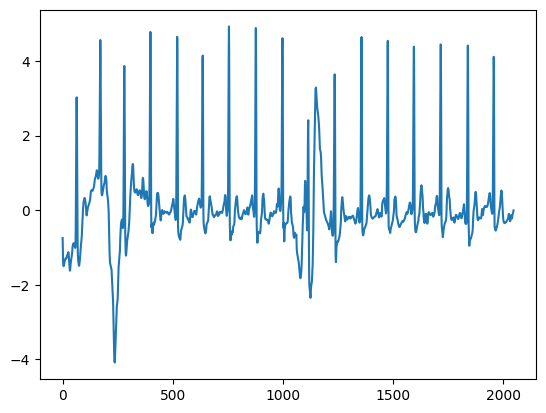

In [5]:
records = torch.from_numpy(np.stack(records)).type(torch.float)
records = torch.unsqueeze(records,-2)
labels = torch.tensor(labels)

rec_mean = torch.mean(records, dim = 2, keepdim = True)
rec_sd = torch.std(records, dim = 2, keepdim = True)
records = (records - rec_mean)/rec_sd

plt.plot(records[0,0])

In [15]:
# Datasety
ds = TensorDataset(records, labels)

train_ds, valid_ds = random_split(ds,[int(.8*len(ds)), len(ds) - int(.8*len(ds))])

# DataLoadery
train_dl = DataLoader(train_ds, 128, shuffle = True)
val_dl = DataLoader(valid_ds, 128, shuffle = True)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
model = nn.Sequential(
	nn.Conv1d(1,8,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(8,16,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(16,32,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(32,64,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(64,128,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Conv1d(128,256,3, padding = 1),
	nn.MaxPool1d(2),
	nn.ReLU(),
	nn.Flatten(),
	nn.Linear(32*256, 256),
	nn.ReLU(),
	nn.Linear(256,4)
).to(device)

In [25]:
optimizer = torch.optim.Adam(model.parameters(),1e-3)
loss_fn = nn.CrossEntropyLoss()

In [26]:
for epoch in range(30):
	for X, y in train_dl:
		X = X.to(device)
		y = y.to(device)
		y_pred = model(X)
		loss = loss_fn(y_pred, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		print(loss.item())

1.3879318237304688
1.2592889070510864
1.184327244758606
1.104976773262024
0.913688063621521
0.9938828349113464
0.9271752834320068
0.8643326759338379
1.069818377494812
0.9598856568336487
0.9235785007476807
1.0265971422195435
0.9158877730369568
0.9553651809692383
0.955371081829071
0.9191306829452515
0.9709630012512207
1.0076587200164795
1.0702885389328003
0.9576159715652466
1.0102479457855225
0.9151071906089783
1.0666699409484863
0.8422788381576538
0.9513061046600342
0.9187556505203247
0.9549852609634399
0.9293423891067505
0.9919655323028564
1.1328544616699219
0.9705977439880371
1.0206323862075806
0.8839123845100403
0.9832969903945923
0.9836048483848572
0.9768322706222534
1.1275643110275269
0.9224514365196228
0.958420991897583
0.9270361661911011
1.0409929752349854
0.9658087491989136
1.024522066116333
0.9776385426521301
0.9505148530006409
0.9190340638160706
0.9135951399803162
1.0005297660827637
0.9560612440109253
1.0174648761749268
0.9996663928031921
1.008545994758606
1.0592334270477295
0

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np

def my_confusion_matrix(dataloader, classes):
    cm = np.zeros((classes, classes))
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_pred = model(X).argmax(dim=1).cpu()
            cm += confusion_matrix(y, y_pred, labels=list(range(classes)))
    return cm.astype(int)

In [27]:
cm = my_confusion_matrix(val_dl, 4)
print(cm)

[[767   8 208   7]
 [ 27  56  69   1]
 [203  31 221   7]
 [ 13   2  21   7]]
